<a href="https://colab.research.google.com/github/avc9/NLPlay-with-Transformers--SoC-2021/blob/main/week2_implimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import sklearn
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import random

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
data=pd.read_csv("/content/drive/MyDrive/SOC-2021 data/IMDB Dataset.csv")
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
stop_words=set(stopwords.words('english'))

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

data['review']=data['review'].apply(denoise_text)
print(data.head(5))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. The filming tec...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [5]:
def stem_tokenizer(text):
  tokenizer=nltk.RegexpTokenizer(r"\w+")
  stemmer=PorterStemmer()
  return [stemmer.stem(word) for word in tokenizer.tokenize(text) if word.lower() not in stop_words]

data['review']=data['review'].apply(stem_tokenizer)
print(data.head(5))
print(data['review'][0])

                                              review sentiment
0  [one, review, mention, watch, 1, Oz, episod, h...  positive
1  [wonder, littl, product, film, techniqu, unass...  positive
2  [thought, wonder, way, spend, time, hot, summe...  positive
3  [basic, famili, littl, boy, jake, think, zombi...  negative
4  [petter, mattei, love, time, money, visual, st...  positive
['one', 'review', 'mention', 'watch', '1', 'Oz', 'episod', 'hook', 'right', 'exactli', 'happen', 'first', 'thing', 'struck', 'Oz', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'GO', 'trust', 'show', 'faint', 'heart', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violenc', 'hardcor', 'classic', 'use', 'word', 'call', 'OZ', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'mainli', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'Em', 'citi', 'home', 'mani', 'aryan', 'mus

In [6]:
def class_pre(val):
  if val=='positive':
    return 1
  else:
    return 0
data['sentiment']=data['sentiment'].apply(class_pre)
print(data.sentiment.value_counts())

1    25000
0    25000
Name: sentiment, dtype: int64


In [7]:
from gensim import corpora

def make_dict(data):
    review_dict = corpora.Dictionary(data['review'])
    return review_dict


review_dict = make_dict(data)

In [8]:
def split_train_test(data, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(data['review'], 
                                                        data['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(data)

Value counts for Train sentiments
0    17512
1    17488
Name: sentiment, dtype: int64
Value counts for Test sentiments
1    7512
0    7488
Name: sentiment, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                             review
0  36322  [sequel, exactli, expect, good, enough, everyo...
1   4638  [pretti, well, known, one, get, deep, basic, s...
2  46808  [made, mistak, buy, sinc, collect, comic, book...
3  38099  [movi, proverbi, 80, flick, show, viewer, long...
4  31461  [absolut, love, movi, child, seem, find, anywh...


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [10]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return F.softmax(out, dim=1)


In [11]:
VOCAB_SIZE = len(review_dict)
NUM_LABELS = 2

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

In [12]:
def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    else:
        return torch.tensor([1], dtype=torch.long, device=device)

In [17]:
VOCAB_SIZE = len(review_dict)

input_dim = VOCAB_SIZE
hidden_dim = 200
output_dim = 2
num_epochs = 26

ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=0.003)

In [14]:
print(ff_nn_bow_model)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=74159, out_features=200, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=200, out_features=2, bias=True)
)


epoch number   1
0.48500758177127157
epoch number   2
0.4196617917707988
epoch number   3
0.40540017738171985
epoch number   4
0.3978624331840447
epoch number   5
0.3915704964407853
epoch number   6
0.3869028840150152
epoch number   7
0.38394410890936853
epoch number   8
0.3824993446741785
epoch number   9
0.3777674894622394
epoch number   10
0.37596051607557707
epoch number   11
0.3723873438060284
epoch number   12
0.37270133303574154
epoch number   13
0.3706075354703835
epoch number   14
0.3690310681751796
epoch number   15
0.3679595217662198
epoch number   16
0.3666178108964648
epoch number   17
0.3655858814009598
epoch number   18
0.36481085030181065
epoch number   19
0.3634265573118414
epoch number   20
0.3621887841122491
epoch number   21
0.3614297447264194
epoch number   22
0.36204143644826753
epoch number   23
0.360107060860736
epoch number   24
0.35950294935703275
epoch number   25
Epoch completed: 25
0.3583930002306189
epoch number   26
0.35682960414631026


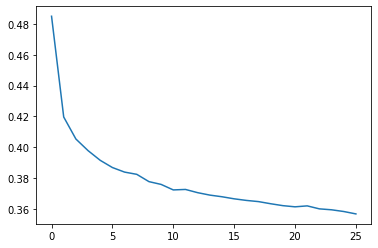

In [18]:
train_loss = []
train_loss_buffer=0

for epoch in range(num_epochs):
    print("epoch number   %d" % (epoch+1))
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    for index, row in X_train.iterrows():
        optimizer.zero_grad()
        bow_vec = make_bow_vector(review_dict, row['review'])       
        probs = ff_nn_bow_model(bow_vec)
        target = make_target(Y_train['sentiment'][index])
        loss = loss_function(probs, target)        
        train_loss_buffer+=loss.item()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_buffer/len(X_train))
    print(train_loss_buffer/len(X_train))
    train_loss_buffer=0
plt.plot(train_loss)


In [20]:
from sklearn.metrics import classification_report
bow_ff_nn_predictions = []
original_lables_ff_bow = []
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['review'])
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      7488
           1       0.85      0.91      0.88      7512

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

